In [1]:
from packages.data_objects.dataset import TorchH5Dataset, autoencoder_unpack_func
from packages.io.torch_dataloaders import get_data_loaders
dataset = TorchH5Dataset(h5_path='/media/lolly/SSD/motor_eeg_dataset/motor_eeg_dataset.h5', unpack_func=autoencoder_unpack_func)
train_loader, _, _ = get_data_loaders(dataset, norm_axes=(0,2), target_norm_axes=(0,2), norm_convergence_threshold=1e-3, batch_size=64)

Calculating normalization parameters (input & target):  98%|█████████▊| 39/40 [00:02<00:00, 17.09it/s, samples=5120, input_conv=0, target_conv=0]


In [24]:
sample = next(iter(train_loader))['input']
print(sample.shape)

torch.Size([64, 32, 640])


In [22]:
from packages.models.wavelet_head import CWTHead, test_cwt_reconstruction
import numpy as np

frequencies = np.logspace(np.log10(0.5), np.log10(79.9), 16)
cwt_head = CWTHead(frequencies=frequencies, fs=160, chunk_samples=160)
frequencies

array([ 0.5       ,  0.70125363,  0.98351331,  1.37938456,  1.93459686,
        2.71328614,  3.80540351,  5.33710605,  7.48532999, 10.49822966,
       14.72384333, 20.65029718, 28.96219173, 40.6196842 , 56.96940203,
       79.9       ])

Reconstruction MSE: 0.0452


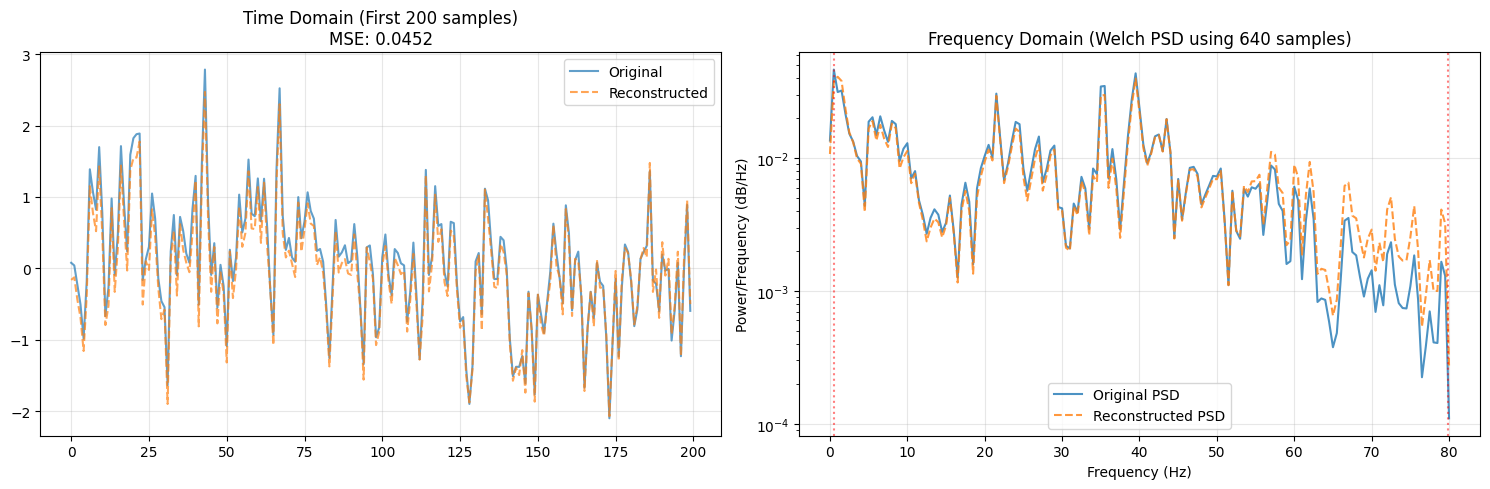

Reconstruction MSE: 0.0274


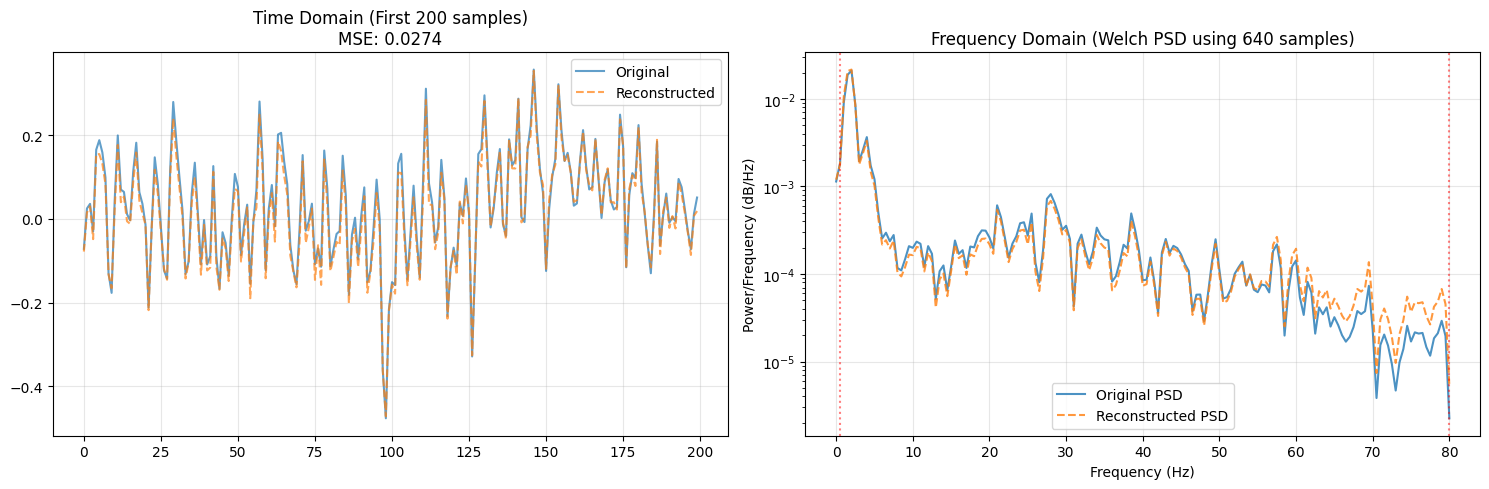

Reconstruction MSE: 0.0467


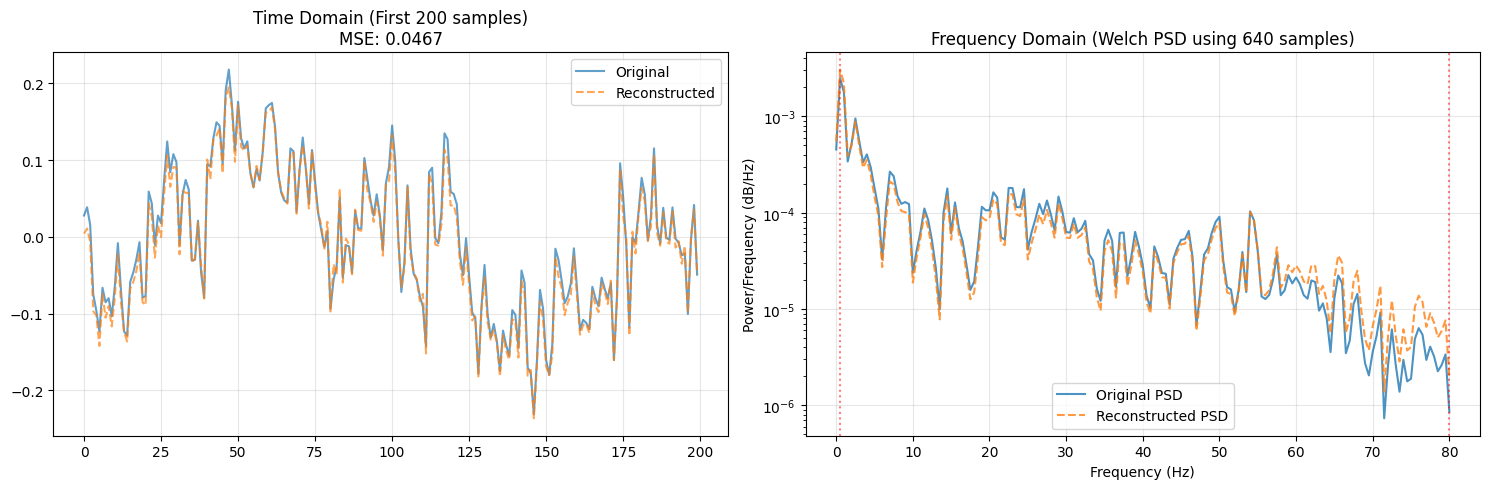

In [28]:
sample = next(iter(train_loader))['input']
test_cwt_reconstruction(cwt_head, sample)
sample = next(iter(train_loader))['input']
test_cwt_reconstruction(cwt_head, sample)
sample = next(iter(train_loader))['input']
test_cwt_reconstruction(cwt_head, sample)

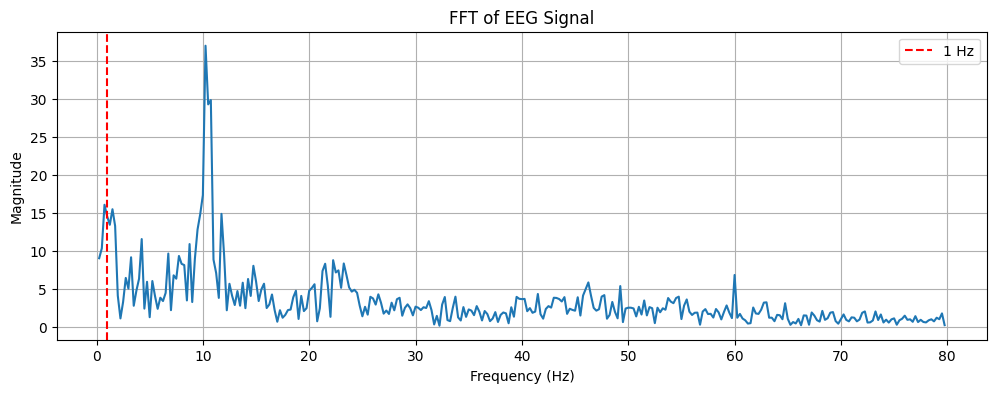

In [17]:
import matplotlib.pyplot as plt

# Get a single sample and compute FFT
sample_data = sample[0, 0, :].cpu().numpy()  # Take first batch, first channel
fft_values = np.fft.fft(sample_data)
fft_freq = np.fft.fftfreq(len(sample_data), 1/160)  # fs=160 from cwt_head

# Plot only positive frequencies
positive_freq_idx = fft_freq > 0

# Create figure FIRST
plt.figure(figsize=(12, 4))

# Plot FFT
plt.plot(fft_freq[positive_freq_idx], np.abs(fft_values[positive_freq_idx]))

# Add vertical line at 1 Hz AFTER creating figure
plt.axvline(x=1, color='red', linestyle='--', label='1 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of EEG Signal')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch, butter, sosfiltfilt

def test_cwt_reconstruction(head, signal):
    """
    Tests info preservation with Time-Domain (slice) and Frequency-Domain (FULL signal) plots.
    """
    B_in, C, Total_Time = signal.shape
    # Ensure fs is int
    fs = int(getattr(head, 'fs', 160)) 
    
    # 1. Forward Pass
    out = head(signal)
    
    # 2. Automatic Unchunking
    if out.shape[0] != B_in:
        B_out = out.shape[0]
        num_chunks = B_out // B_in
        chunk_time = out.shape[-1]
        _, *feats, _ = out.shape 
        out = out.view(B_in, num_chunks, *feats, chunk_time)
        out = out.permute(0, 2, 3, 4, 5, 1, 6)
        out = out.reshape(B_in, *feats, Total_Time)
        
    # 3. Reconstruct
    valid_pixels = out[:, :, :, head.rows, head.cols, :]
    mag = valid_pixels[:, 0, ...]
    phase = valid_pixels[:, 1, ...]
    complex_cwt = mag * torch.exp(1j * phase)
    
    # --- FIX: FREQUENCY COMPENSATION ---
    # Because we used L2 norm filters, we need to scale by sqrt(Freq) 
    # to recover a flat spectrum in the summation.
    # (Approximate correction factor)
    freqs = torch.tensor(head.frequencies, device=complex_cwt.device).view(1, -1, 1, 1)
    complex_cwt = complex_cwt * torch.sqrt(freqs) 
    
    reconstructed = complex_cwt.real.sum(dim=1)
    
    # 4. Reference & Scaling
    reference_signal = signal - signal.mean(dim=-1, keepdim=True)
    numerator = (reconstructed * reference_signal).sum(dim=-1, keepdim=True)
    denominator = (reconstructed * reconstructed).sum(dim=-1, keepdim=True)
    scale_factor = numerator / (denominator + 1e-8)
    reconstructed *= scale_factor
    
    # 5. MSE
    mse = torch.nn.functional.mse_loss(reconstructed, reference_signal)
    print(f"Reconstruction MSE: {mse.item():.4f}")
    
    # --- PLOTTING ---
    # Move FULL SIGNALS to CPU for plotting
    sig_cpu = reference_signal[0, 0, :].detach().cpu().numpy()
    rec_cpu = reconstructed[0, 0, :].detach().cpu().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Time Domain (Just a slice to see wiggles)
    display_len = min(200, Total_Time)
    ax1.plot(sig_cpu[:display_len], label="Original", alpha=0.7)
    ax1.plot(rec_cpu[:display_len], '--', label="Reconstructed", alpha=0.7)
    ax1.set_title(f"Time Domain (First {display_len} samples)\nMSE: {mse.item():.4f}")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Frequency Domain (Uses FULL SIGNAL for high res)
    # Use nperseg = Total_Time // 2 or 256, whichever is larger, to get good freq resolution
    nperseg = max(256, len(sig_cpu) // 2)
    nperseg = min(nperseg, len(sig_cpu)) # Cap at signal length
    
    f_orig, p_orig = welch(sig_cpu, fs=fs, nperseg=nperseg)
    f_rec, p_rec = welch(rec_cpu, fs=fs, nperseg=nperseg)
    
    ax2.semilogy(f_orig, p_orig, label="Original PSD", alpha=0.8)
    ax2.semilogy(f_rec, p_rec, '--', label="Reconstructed PSD", alpha=0.8)
    ax2.set_title(f"Frequency Domain (Welch PSD using {len(sig_cpu)} samples)")
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Power/Frequency (dB/Hz)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Mark CWT Range on Plot
    # Assuming frequencies might be tensor or list
    if isinstance(head.frequencies, torch.Tensor):
        freqs_list = head.frequencies.cpu().numpy()
    else:
        freqs_list = head.frequencies
        
    min_f, max_f = np.min(freqs_list), np.max(freqs_list)
    ax2.axvline(x=min_f, color='r', linestyle=':', alpha=0.5, label='CWT Limits')
    ax2.axvline(x=max_f, color='r', linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# 2. Metrics
# ============================================================================

def calculate_spectral_distortion(sig_orig, sig_recon, fs):
    """Log-Spectral Distance (LSD)"""
    f_orig, p_orig = welch(sig_orig, fs=fs, nperseg=min(256, len(sig_orig)))
    f_rec, p_rec = welch(sig_recon, fs=fs, nperseg=min(256, len(sig_recon)))
    
    eps = 1e-10
    log_p_orig = 10 * np.log10(p_orig + eps)
    log_p_rec = 10 * np.log10(p_rec + eps)
    
    lsd = np.mean((log_p_orig - log_p_rec) ** 2)
    return np.sqrt(lsd)

def calculate_correlation(sig_orig, sig_recon):
    vx = sig_orig - np.mean(sig_orig)
    vy = sig_recon - np.mean(sig_recon)
    return np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))

# ============================================================================
# 3. Reconstruction Logic (Pure Math, no plotting)
# ============================================================================
def run_reconstruction(head, signal):
    """
    Reconstruction logic that properly handles the spatial grid.
    """
    B_in, C, Total_Time = signal.shape
    out = head(signal)
    
    # Handle chunking if present
    if out.shape[0] != B_in:
        B_out = out.shape[0]
        num_chunks = B_out // B_in
        chunk_time = out.shape[-1]
        _, *feats, _ = out.shape 
        out = out.view(B_in, num_chunks, *feats, chunk_time)
        out = out.permute(0, 2, 3, 4, 5, 1, 6)
        out = out.reshape(B_in, *feats, Total_Time)
    
    # Extract valid pixels using the actual channel positions
    # out shape: (B, 2, Freq, H, W, T)
    # Extract at actual channel positions
    valid_pixels = out[:, :, :, head.rows, head.cols, :]  # (B, 2, Freq, C, T)
    
    mag = valid_pixels[:, 0, ...]      # (B, Freq, C, T)
    phase = valid_pixels[:, 1, ...]    # (B, Freq, C, T)
    
    complex_cwt = mag * torch.exp(1j * phase)  # (B, Freq, C, T)
    
    # Frequency compensation
    freqs = torch.tensor(head.frequencies, device=complex_cwt.device).view(1, -1, 1, 1)
    complex_cwt = complex_cwt * torch.sqrt(freqs)
    
    # Sum over frequencies (dim=1) to get (B, C, T)
    reconstructed = complex_cwt.real.sum(dim=1)  # (B, C, T)
    
    # Reference signal
    ref = signal - signal.mean(dim=-1, keepdim=True)  # (B, C, T)
    
    # Scale factor calculation (per channel)
    num = (reconstructed * ref).sum(dim=-1, keepdim=True)      # (B, C, 1)
    den = (reconstructed * reconstructed).sum(dim=-1, keepdim=True)  # (B, C, 1)
    scale = num / (den + 1e-8)
    
    reconstructed *= scale
    
    return reconstructed, ref


def calculate_correlation(sig_orig, sig_recon):
    """Pearson correlation with NaN handling."""
    vx = sig_orig - np.mean(sig_orig)
    vy = sig_recon - np.mean(sig_recon)
    
    # Check for zero variance
    std_x = np.sqrt(np.sum(vx ** 2))
    std_y = np.sqrt(np.sum(vy ** 2))
    
    if std_x < 1e-10 or std_y < 1e-10:
        return 0.0  # Return 0 instead of NaN for zero variance
    
    return np.sum(vx * vy) / (std_x * std_y)


def find_optimal_frequencies(n_samples=10, n_channels=8):
    """
    Test with multiple samples and channels for robust statistics.
    
    Args:
        n_samples: Number of independent signals to test
        n_channels: Number of channels per sample
    """
    print(f"Generating {n_samples} Synthetic Signals with {n_channels} channels each...")
    fs = 160
    T = 640
    
    # Generate multiple samples with multiple channels
    all_signals = []
    for _ in range(n_samples):
        # Generate 1/f noise for all channels
        white = np.random.randn(1, n_channels, T)
        fft = np.fft.rfft(white, axis=-1)
        freqs_fft = np.fft.rfftfreq(T)
        fft[:, :, 1:] /= np.sqrt(freqs_fft[1:])
        pink = np.fft.irfft(fft, n=T, axis=-1)
        
        # Bandpass filter
        sos = butter(4, [0.5, 79.9], btype='bandpass', fs=fs, output='sos')
        signal_np = sosfiltfilt(sos, pink, axis=-1)
        
        # Normalize
        signal_np = signal_np / (np.std(signal_np, axis=-1, keepdims=True) + 1e-8)
        
        all_signals.append(signal_np)
    
    # Stack all samples: (n_samples, n_channels, T)
    all_signals = np.concatenate(all_signals, axis=0)
    signal = torch.from_numpy(all_signals).float()
    
    print(f"Signal shape: {signal.shape}")
    print(f"Signal mean: {signal.mean().item():.4f}, std: {signal.std().item():.4f}")
    
    results = {'n': [], 'mse': [], 'mse_std': [], 'lsd': [], 'lsd_std': [], 'corr': [], 'corr_std': []}
    freq_counts = [4, 8, 10, 12, 16, 24, 32, 40, 48, 56, 64]
    
    print(f"\n{'N':<5} | {'MSE':<12} | {'LSD':<12} | {'Corr':<12}")
    print("-" * 50)
    
    for n in freq_counts:
        # Setup Model
        f_list = np.logspace(np.log10(0.5), np.log10(80), n)
        
        model = CWTHead(
            frequencies=f_list, 
            fs=fs, 
            num_channels=n_channels, 
            n_cycles=6.0,
            trainable=False
        )
        
        # Run reconstruction
        rec, ref = run_reconstruction(model, signal)
        
        # Calculate metrics per sample and channel
        mse_vals = []
        lsd_vals = []
        corr_vals = []
        
        for sample_idx in range(n_samples):
            for ch_idx in range(n_channels):
                ref_np = ref[sample_idx, ch_idx].detach().numpy()
                rec_np = rec[sample_idx, ch_idx].detach().numpy()
                
                # MSE
                mse = np.mean((ref_np - rec_np) ** 2)
                mse_vals.append(mse)
                
                # LSD
                lsd = calculate_spectral_distortion(ref_np, rec_np, fs)
                lsd_vals.append(lsd)
                
                # Correlation
                corr = calculate_correlation(ref_np, rec_np)
                corr_vals.append(corr)
        
        # Statistics across all samples and channels
        mse_mean = np.mean(mse_vals)
        mse_std = np.std(mse_vals)
        lsd_mean = np.mean(lsd_vals)
        lsd_std = np.std(lsd_vals)
        corr_mean = np.mean(corr_vals)
        corr_std = np.std(corr_vals)
        
        print(f"{n:<5} | {mse_mean:.4f}±{mse_std:.4f} | {lsd_mean:.4f}±{lsd_std:.4f} | {corr_mean:.4f}±{corr_std:.4f}")
        
        results['n'].append(n)
        results['mse'].append(mse_mean)
        results['mse_std'].append(mse_std)
        results['lsd'].append(lsd_mean)
        results['lsd_std'].append(lsd_std)
        results['corr'].append(corr_mean)
        results['corr_std'].append(corr_std)
    
    # Plotting with error bars
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # MSE with error bars
    axes[0].errorbar(results['n'], results['mse'], yerr=results['mse_std'], 
                     fmt='o-', capsize=5, capthick=2)
    axes[0].set_title(f"MSE vs Number of Frequencies\n({n_samples} samples × {n_channels} channels)")
    axes[0].set_xlabel("N Frequencies")
    axes[0].set_ylabel("MSE")
    axes[0].grid(True, alpha=0.3)
    
    # LSD with error bars
    axes[1].errorbar(results['n'], results['lsd'], yerr=results['lsd_std'],
                     fmt='o-', color='orange', capsize=5, capthick=2)
    axes[1].set_title("Log-Spectral Distance")
    axes[1].set_xlabel("N Frequencies")
    axes[1].set_ylabel("LSD (dB)")
    axes[1].grid(True, alpha=0.3)
    
    # Correlation with error bars
    axes[2].errorbar(results['n'], results['corr'], yerr=results['corr_std'],
                     fmt='o-', color='green', capsize=5, capthick=2)
    axes[2].set_title("Correlation")
    axes[2].set_xlabel("N Frequencies")
    axes[2].set_ylabel("Pearson r")
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.show()
    
    # Find elbow point using mean values
    mse_array = np.array(results['mse'])
    n_array = np.array(results['n'])
    
    # Normalized improvements
    mse_norm = (mse_array - mse_array.min()) / (mse_array.max() - mse_array.min() + 1e-8)
    improvements = np.diff(mse_norm)
    
    # Find where improvement drops below threshold
    threshold = 0.05
    elbow_idx = np.where(np.abs(improvements) < threshold)[0]
    
    if len(elbow_idx) > 0:
        elbow_n = n_array[elbow_idx[0] + 1]
        print(f"\nRecommended number of frequencies (elbow point): {elbow_n}")
    else:
        print(f"\nNo clear elbow found. Consider using {n_array[len(n_array)//2]} frequencies.")
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"SUMMARY STATISTICS ({n_samples*n_channels} total measurements)")
    print(f"{'='*60}")
    for i, n in enumerate(results['n']):
        print(f"N={n:3d}: MSE={results['mse'][i]:.4f}±{results['mse_std'][i]:.4f}, "
              f"LSD={results['lsd'][i]:.4f}±{results['lsd_std'][i]:.4f}, "
              f"Corr={results['corr'][i]:.4f}±{results['corr_std'][i]:.4f}")
    
    return results


if __name__ == "__main__":

    find_optimal_frequencies(n_samples=100, n_channels=32)